In [1]:
import numpy as np
from scipy import optimize
from sympy import *
from scipy.integrate import odeint



This script describes different methods to obtain the steady states or equilibrium points of a systems. 

Those values can be obtained by setting the differential equation to zero and solving for $u$

$$\frac{\partial u}{\partial t} = 0$$

Several methods can be used to compute the steady state $U^*$. In this notebook, we will follow a python implementation of the analytical method, the ODE method, and the Crank-Nicolson.

The system used as an example is a reaction-diffusion model.


$$\frac{\partial u}{\partial t} = a-u+u^2v +  D_u \frac{\partial^2 u}{\partial x^2} ,$$

$$\frac{\partial v}{\partial t} = \frac{b}{(a+b)^2} +  D_v \frac{\partial^2 v}{\partial x^2} $$ 




### Analytical method

Most accurate and computationally efficient way to calculate steady states. However, it only works for simple systems such as the PDE. More complex systems such as the atlas topologies which contain Hill terms cannot be computed analytically. 

The following expression is obtained using pen and paper but $sympy.solve()$ can also compute an analytical expression of the steady state.



In [2]:
a = 0
b =1.1
Ustar_analytic = [a+b, b/(a+b)**2] 
print('Steady state')
print(Ustar_analytic)

Steady state
[1.1, 0.9090909090909091]


### ODE solver

In [3]:
def PDE(u,t,params = [0,1.1]): 
    a,b = params
    f_u0 = a - u[0] + (u[0]**2)*u[1]
    f_u1 = b - (u[0]**2)*u[1]
    return f_u0,f_u1

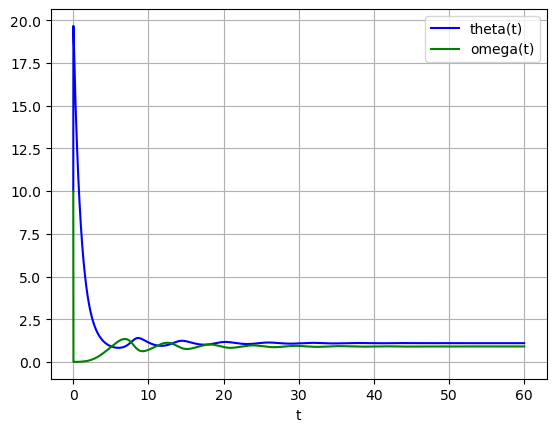

Steady state
[1.1008924  0.90880478]


In [4]:
T=60
t = np.linspace(0, T, T*1000)
sol = odeint(PDE, [10,10], t)
import matplotlib.pyplot as plt
plt.plot(t[:], sol[:, 0], 'b', label='theta(t)')
plt.plot(t[:], sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
Ustar_ODE=sol[-1]
print('Steady state')
print(Ustar_ODE)

### Newton-Raphson method

In numerical analysis, Newton's method, also known as the Newton–Raphson method, named after Isaac Newton and Joseph Raphson, is a root-finding algorithm which produces successively better approximations to the roots (or zeroes) of a real-valued function.

This is the algorithm of choice for more complex systems which do not have an analytical solution, or where the solution is hard to obtain. It is more accurate than the ODE solver method.

This algorithm needs as an input the function, the jacobian and an initial condition

In [5]:
#Definition of PDE and Jacobian functions

# #PDE system
def PDE(u,params = [0,1.1]):
    a,b = params
    f_u0 = a - u[0] + (u[0]**2)*u[1]
    f_u1 = b - (u[0]**2)*u[1]
    return f_u0,f_u1

# #Jacobian of PDE system
def jacobian_PDE():
    U,V=symbols('U'),symbols('V')
    functions = Matrix(PDE([U,V]))
    jacobian_matrix = functions.jacobian([U,V])
    return jacobian_matrix






In [6]:
#Definition of functions to sample initial conditions with latin hypercube sampling.

#This function return a loguniform distribution with values from 10^low to 10^high
def loguniform(low=-3, high=3, size=None):
    return (10)**(np.random.uniform(low, high, size))

# - This function accepts an already existing distribution and a required number of samples
# and outputs an array with samples distributed in a latin-hyper-cube sampling manner.
def lhs_list(data,nsample):
    m,nvar = data.shape
    ran=np.random.uniform(size=(nsample,nvar))
    s=np.zeros((nsample,nvar))
    for j in range(0,nvar):
        idx=np.random.permutation(nsample)+1
        P=((idx-ran[:,j])/nsample)*100
        s[:,j]= np.percentile(data[:,j],P)
    return s

# - Input number of initial conditions needed and the number of species in each sample obtain an array with the
# initial conditions distributed in a lhs manner.
def lhs_initial_conditions(n_initialconditions=10,n_species=2):
    data = np.column_stack(([loguniform(size=100000)]*n_species))
    initial_conditions = lhs_list(data,n_initialconditions)
    return np.array(initial_conditions,dtype=np.float)



In [10]:
#Definition of newton raphson algorithm function to find steady states

def newton_raphson(x_guess, max_num_iter=15, tolerance=0.0001, alpha=1):
    '''
    Function for representing a Newton-Raphson iteration for multidimensional systems of equations
    :param f: function class that must define the following methods:
        - numDims(): Method that returns an integer number of variables in the system of equations
        - getJacobian(np.ndarray): Method to compute the Jacobian of the system of equations at the current root estimate.The output is an n by n matrix where n is the number of variables in the system of equations
		- __call__(np.ndarray): Method to make this class act like a function operating on some input x
    :param x_guess: an initial guess for the Newton-Raphson iteration
    :param max_num_iter: a maximum number of iterations that will be taken
    :param tolerance: a tolerance that will stop the sequence once the error drops below it
    :param alpha: A coefficient that can tune the Newton-Raphson stepsize. Recommend setting alpha <= 1.
    :return: A tuple with the root estimate, final error for the root, and the number of iterations it took
    '''

    # set the initial guess
    x = x_guess

    # compute function value at initial guess
    fx = PDE(x)


    # define the initial value for the error and the starting iteration count
    err = np.linalg.norm(fx)
    iter = 0
    
    # perform the Newton-Raphson iteration algo
    while err > tolerance and iter < max_num_iter and np.all(x!=0):
#         print (x)

        jac = jacobian_PDE()
        U,V= symbols('U'),symbols('V')
        jac = jac.subs(U,x_guess[0])
        jac = jac.subs(V,x_guess[1])
        jac = np.array(jac,dtype=float)

        # perform newton step
        x = x - alpha*np.linalg.solve(jac,fx)

        # update the function value at the new root estimate
        fx = PDE(x)


        # compute the current root error
        err = np.linalg.norm(fx)

        # update the iteration counter
        # print("Iteration {0}: Error of {1} with an estimate of {2}".format(iter, err, x))

        iter = iter + 1
    if err < tolerance:
        if sum(item < 0 for item in x) == 0 : #check that there are no negatives
            return (x, err, 0)



In [11]:
#This function takes a list of initial conditions and returns a list of steady states found from those initial condition.
#It also checks if the steady state found is similar to any previous steady states found and only adds it to the list if it is not similar.

def newtonraphson_run(initial_conditions):
    count=0
    SteadyState_list = []
    for n in range(len(initial_conditions)):
        xn=[]
        xn = newton_raphson(initial_conditions[n])
            
        if xn != None:  #the algorithm has found a steady state from this initial condition
            if count == 0: #Always add to add clusteredsteadystates in the first iteration of this for loop.
                SteadyState_list.append(xn[0])
                count+=1
            if count > 0: #if not the first iteration, the steady state it must be compared against previous steady states stored to see if its the same
                logiclist = []
                for i in range(count):
                    logiclist.append(np.allclose(SteadyState_list[i], xn[0], rtol=10**-2, atol=0)) #PROCEED IF NO TRUES FOUND
                if not True in logiclist: #no similar steady states previously found
                    SteadyState_list.append(xn[0])
                    
                    count +=1

    return SteadyState_list


In [12]:
#Code to run steady state finding including generation of intiial conditions and finding of steady states
np.random.seed(2)
initial_conditions1 = lhs_initial_conditions(n_initialconditions=10,n_species=2)   #obtain lhs sample for initial conditions
SteadyState_list = newtonraphson_run(initial_conditions1) #

for i in SteadyState_list:
    print(i)
    Ustar_NewtonRaphson=i


[1.1       0.9091477]


/var/folders/bt/1cqt3cks1sl9cz4dfwlyxhpm0000gn/T/ipykernel_14353/822025524.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(initial_conditions,dtype=np.float)
/var/folders/bt/1cqt3cks1sl9cz4dfwlyxhpm0000gn/T/ipykernel_14353/809861569.py:6: RuntimeWarning: overflow encountered in double_scalars
  f_u0 = a - u[0] + (u[0]**2)*u[1]
/var/folders/bt/1cqt3cks1sl9cz4dfwlyxhpm0000gn/T/ipykernel_14353/809861569.py:7: RuntimeWarning: overflow encountered in double_scalars
  f_u1 = b - (u[0]**2)*u[1]


#### Comparison of method's accuracy

In [13]:
print(Ustar_analytic, PDE(Ustar_analytic))
print(Ustar_ODE, PDE(Ustar_ODE))
print(Ustar_NewtonRaphson, PDE(Ustar_NewtonRaphson))

[1.1, 0.9090909090909091] (0.0, 0.0)
[1.1008924  0.90880478] (0.0005463499823277207, -0.0014387485587969984)
[1.1       0.9091477] (6.872131348067967e-05, -6.872131348067967e-05)


This system has one steady state